In [31]:
from os import getcwd, chdir
import re
import numpy as np
import pickle as pk
import pandas as pd

from nltk.metrics import ConfusionMatrix
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.classify import accuracy
from nltk.tokenize import word_tokenize as wt

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

# Change your path here
folder_path = "/home/ethi/ethi/nus/New_Media/Workshops/Data"
chdir(folder_path) 

trainset = pk.load(open("trainset.pk",'rb'),encoding="latin-1")
testset = pk.load(open("testset.pk",'rb'),encoding="latin-1")

Tokenize the data. The NLTK classifiers generally use a dict. To be able to use these classifiers, we use a mapping function written below. This mapping function "word_feats" then transfrom the test and training sets into a structure that can be used by the NLTK classifiers.

In [32]:
train_tokenized = [[wt(x), c] for x,c in trainset]
test_tokenized  = [[wt(x), c] for x,c in testset]

def word_feats(words):
    return dict([(word, True) for word in words])
train_featureset = [(word_feats(d), c) for (d,c) in train_tokenized]
test_featureset  = [(word_feats(d), c) for (d,c) in test_tokenized]

### Naive Bayes Classifier
The Naive Bayes classifier uses Bayes rule to generate the conditional probabilties of each class occuring depending on the word features. It is a _generative classifier_ (in that it generates such conditional probabilities. In the generation of such conditional probabilities, it also considers independence amongst the word features. In other words, it does not consider sentence structure nor word order. A key advantage of Naive Bayes is its computational efficiency. The sklearn function below MultinomialNB() uses a slightly different algorithm in that it considers the frequency of the word count which the Naive Bayes doesn not. Would this feature be helpful in sentiment classification?

#### Classification criteria
$$
 \begin{align}
  \hat{y} =& \underset{k\in \{1, \ldots , K\}}{argmax} \quad \underbrace{p(C_k)}_{prior\ prob} \Pi^n_{i=1} \underbrace{p(x_i | C_k)}_{conditional\ prob}  \\  \\
   =& \underset{k\in \{1, \ldots , K\}}{argmax} \quad log (p(C_k))  \sum^n_{i=1} log\ p(x_i | C_k) 
  \end{align}
$$
Each of the k refers to a class. In this case, there are only two classes - positive and negative sentiment.The $p(C_k)$ are prior probabilities. In layman's terms, Naive Bayes Classifier classifies the _test document_ to the class with the highest probability. This is a recurring theme in sentiment analysis classifier.

For eg, the multinomial Naive Bayes differs only in the computation of the $p(x_i | C_k)$. Later we see that the MaxEnt uses a weighted probability form.

In [33]:
## Naive Bayes Rule using nltk
classifier_nb = NaiveBayesClassifier.train(train_featureset)
print("Accuracy :" +str(accuracy(classifier_nb, test_featureset)))
classifier_nb.show_most_informative_features(15)

## Preparing the data first for sklearn
train_nolab = [t[0].encode("utf-8") for t in trainset]
test_nolab = [t[0].encode("utf-8") for t in testset]

train_lab = [t[1] for t in trainset]
test_lab = [t[1] for t in testset]
# Create your Vectorizer function
vectorizer = TfidfVectorizer()
# Create TF-IDF Vectorizer from your training features
train_vectors = vectorizer.fit_transform(train_nolab)

# Transform your test features to fit your already trained TF-IDF
test_vectors = vectorizer.transform(test_nolab)

## Naive Bayes Rule using sklearn
clf = MultinomialNB().fit(train_vectors, train_lab)
predNB = clf.predict(test_vectors)
pred = list(predNB)
cm = ConfusionMatrix(pred, test_lab)
print (cm)

Accuracy :0.7400315831030398
Most Informative Features
                   ramen = True               -1 : 1      =     40.9 : 1.0
              flavorless = True               -1 : 1      =     38.5 : 1.0
            unacceptable = True               -1 : 1      =     32.4 : 1.0
                  rudely = True               -1 : 1      =     28.5 : 1.0
                  brazil = True               -1 : 1      =     26.8 : 1.0
               redeeming = True               -1 : 1      =     24.5 : 1.0
               poisoning = True               -1 : 1      =     24.2 : 1.0
              microwaved = True               -1 : 1      =     24.0 : 1.0
                   worst = True               -1 : 1      =     23.6 : 1.0
               disgusted = True               -1 : 1      =     23.4 : 1.0
              disgusting = True               -1 : 1      =     22.5 : 1.0
               tasteless = True               -1 : 1      =     21.2 : 1.0
                     ugh = True              

The most informative features shows the 'key' words that appear more in the positive reviews than the positive reviews. For eg., for the trainset, the most informative classifier is the 'ramen' which for every one bad review, appears in 40.8 positive reviews. Can you do the same for the test_featureset? What is the most informative feature instead? Had you used 'alike' corpus, the accuracy would have been higher.

In this simple demonstration, you observe the importance of the training corpus. Notice that 'ramen' is a noun. Some corpus like to consider only 'non-subjective' nouns or only adjective and verbs to label texts. There is no right or wrong answer here. There are many things that are not considered in this naive Bayes classifier such as 'word senses', which are found in  the WordNet.

We next test the Naive Bayes classifier on the test_featureset itself. Can you calculate the precision and recall in this case? 

In [34]:
predictions_nb = []
actuals    = [t[1] for t in test_featureset]

test_nolab = [t[0] for t in test_featureset]

for t in test_nolab:
    predictions_nb.append(classifier_nb.classify(t))
    
cm = ConfusionMatrix(predictions_nb, actuals)
print (cm)

   |    -      |
   |    1    1 |
---+-----------+
-1 |<3016>1267 |
 1 |   50 <733>|
---+-----------+
(row = reference; col = test)



### Maximum Entropy Classifier (MaxEnt)

This classifier takes 1-2 hours for training. We use a pickled version for classification. The Maximum entropy classifier is a discriminative classifier in that it looks at the entire dataset and uses a model (normally via optimisation) with parameters to map (_classify_) labels. As such, it is more computationally intensive than the Naive Bayes. Due to the model, it also does not assume conditional independence amongst the different word features. When is a good time to use the MaxEnt model? When little information is known about the prior distribution. Refer back to the excel sheet where this prior distribution comes about.

#### Algorithm
The MaxEnt classifier is similar to the Naive Bayes classifier except for a different form of the probability function. It uses instead the _empirical_ distribution - which assumes the least known about the prior distribution. This is in accordance to the Principle of Max Entropy.

$$ 
  P(c|d,\lambda) = \frac{exp\sum_i\lambda_i f_i (c,d)}{\sum_{c'\in C}exp\sum_i \underbrace{f_i(c',d)}}_{empirical\ distribution}
$$

The empirical _joint_ distribution is obtained for each word $w$ and class $c\in C$ as $f(w,c) = \frac{x}{N}$. Here $x$ is the number of times that $w$ occurs in a document of class $c$ and $N$ is the total no of train set. The $\lambda_i$'s are obtained via optimisation in a trained model for each word $w$. This is performed in the code below.

In [35]:
#classifier1 = nltk.MaxentClassifier.train(train_featureset, algorithm="IIS", max_iter=2) 
# IIS - improved iterative scaling - optimisation algorithm
#pk.dump(classifier_me, open("maxent.pk","wb"))
# pickle the classifier
classifier_me = pk.load(open("maxent.pk","rb"),encoding='latin-1')
print(accuracy(classifier_me, test_featureset))

0.4281484405842874


In [36]:
predictions_me = []

for t in test_nolab:
    predictions_me.append(classifier_me.classify(t))

cm = ConfusionMatrix(predictions_me, actuals)
print(cm)

   |    -      |
   |    1    1 |
---+-----------+
-1 | <185>  16 |
 1 | 2881<1984>|
---+-----------+
(row = reference; col = test)



What is the precision and recall/ accuracy of the Max Entropy classifier compared to the Naive Bayes classifier? Observe it is lower than the NB.

### Features - Negation:

The negation feature is very important as it reverse the polarity of the reviews with 'positive' words. The method we use here is attributed to Satyajit Das - a very simple technique. It is to label the words with a suffix $_neg$ till the next punctuation symbol. This adds new features for classification.


In [37]:
def neg_tag(text):
    transformed = re.sub(r"\b(?:never|nothing|nowhere|noone|none|not|haven't|hasn't|hasnt|hadn't|hadnt|can't|cant|couldn't|couldnt|shouldn't|shouldnt|won't|wont|wouldn't|wouldnt|don't|dont|doesn't|doesnt|didn't|didnt|isnt|isn't|aren't|arent|aint|ain't|hardly|seldom)\b[\w\s]+[^\w\s]", lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), text, flags=re.IGNORECASE)
    return(transformed)

text = "I don't like that place you keep calling awesome."
print(neg_tag(text))

# Create a training list which will now contain reviews with Negatively tagged words and their labels
train_set_neg = []

# Append elements to the list
for doc in trainset:
    trans = neg_tag(doc[0])
    lab = doc[1]
    train_set_neg.append([trans, lab])

# Create a testing list which will now contain reviews with Negatively tagged words and their labels
test_set_neg = []

# Append elements to the list
for doc in testset:
    trans = neg_tag(doc[0])
    lab = doc[1]
    test_set_neg.append([trans, lab])

I don't NEG_like NEG_that NEG_place NEG_you NEG_keep NEG_calling NEG_awesome.


In [38]:
print(test_set_neg[0])

['we eat here for lunch about twice a month (since 2010)  - always for sandwiches. we generally get the italian, and another. their chip selection is pretty limited though.', 1]


###  Features - tf-idf:
term-frequency - inverted document frequency.
A tf-idf expresses a document as a sparse "word-matrix". The importance of a word is also dependent on how often it appears in the entire training set. By default, sklearn uses "single" words to form the tf-idf, but it is possible to specify bigrams, trigrams etc.; and also to specify bounds on the document-frequency.


In [39]:
# Using tf-idf as features for training
# sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
train_nolab = [t[0].encode("utf-8") for t in train_set_neg]
test_nolab = [t[0].encode("utf-8") for t in test_set_neg]

train_lab = [t[1] for t in train_set_neg]
test_lab = [t[1] for t in test_set_neg]
vectorizer = TfidfVectorizer()

# this is used below for training the SVM
train_vectors = vectorizer.fit_transform(train_nolab)
test_vectors = vectorizer.transform(test_nolab)

# Ascertain shape of the sparse matrix
print ("Train matrix shape " + str(train_vectors.shape))
print ("Test matrix shape " + str(test_vectors.shape))


Train matrix shape (20329, 43270)
Test matrix shape (5066, 43270)


In the shape above, observe that there are 43270 "word" features and and 20329 documents in the train set. Vice versa, there are 5066 doucments in the test set. This is a relatively 'high-dimension' feature, which we use as an input to the SVM classifier. Observe some of the varied feature words below. 

In [40]:
print("Word Features ")
print(vectorizer.get_feature_names()[5000:5050])
termperdoc = vectorizer.inverse_transform(vectorizer.get_feature_names()[5000:5050])


Word Features 
['cages', 'cai', 'caibatta', 'cain', 'caiparinha', 'caipirinha', 'caitlin', 'cajun', 'cajuny', 'cak', 'cake', 'cakebread', 'caked', 'cakes', 'cakey', 'cal', 'calabacitas', 'calabasas', 'calabassas', 'calabrese', 'calada', 'calaloo', 'calamansi', 'calamari', 'calazone', 'calcium', 'calculate', 'calculated', 'calculation', 'calculations', 'calculator', 'calculators', 'calculus', 'caldereta', 'caldo', 'calendar', 'calendars', 'calender', 'calenders', 'calgon', 'cali', 'caliber', 'calibrating', 'calico', 'caliente', 'calif', 'california', 'californian', 'californians', 'calimari']


In [41]:
# SVM Classifier from sklearn
def train_svm(X, y):
    """
    Create and train the Support Vector Machine.
    """
    svm = SVC(C=10000.0, gamma='auto', kernel='rbf')
    svm.fit(X, y)
    return svm

# Pickled model as it takes ahwile for generation
# classifier_svm = train_svm(train_vectors, train_lab)
# pk.dump(classifier_svm, open("classifier_svm.pk","wb"))
classifier_svm = pk.load(open("classifier_svm.pk", "rb"),encoding="latin-1")
predSVM = classifier_svm.predict(test_vectors)
pred = list(predSVM)
cm = ConfusionMatrix(pred, test_lab)
print(cm)
print(classification_report(pred,  test_lab))

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.19.0 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


   |    -      |
   |    1    1 |
---+-----------+
-1 |<2738> 198 |
 1 |  328<1802>|
---+-----------+
(row = reference; col = test)

             precision    recall  f1-score   support

         -1       0.89      0.93      0.91      2936
          1       0.90      0.85      0.87      2130

avg / total       0.90      0.90      0.90      5066



In [42]:
# #write predicted result to file
# test_file  = pd.read_csv(folder_path+"/test.csv")
# test_file["score"] =pred
# test_file.to_csv("test_scored.csv")

In [50]:
 d = {'text': test_nolab, 'label': test_lab, 'score': pred}
df = pd.DataFrame(data=d)
df.to_csv("test_scored.csv")


### More on the SVM Classifier

The SVM classifier is a linear non-probabilitic classifer often used in NLP. It is a non-praobilistics in that it doesnt premise on conditional probability, unlike the Naive Bayes nor Maximum Entropy. It works on the principle of some support vectors which help to define optimal hyperplanes. Not all the feature points are needed to define the support vector. In a way only the most informative feature points help to define the support vector which makes the SVM ideal for high-dimensional classification and sparse matrics common in NLP. The SVM also works on feature points that are not linearly separable through kernel transformation of the feature points.
The SVM solves a constrained optimisation to define this optimal hyperplane. As you can see in the figure below, this optimal hyperplane has the maximum margin between the support features. The optimisation equation is 
$$ \begin{align}
   \underset{\gamma, w, b}{max} \quad &\gamma \\
      s.t. \quad & y^{(i)}( w^T x^{(i)} + b)  \geq \gamma, \quad i=1,\cdots,m \\
       & ||w|| \equiv 1
   \end{align}
$$
Here $w^T$ is the coefficient for each feature and $b$ is a constant. $y^{(i)}$ is the training label - 1 or 0, and $\gamma$ is the margin (distance from the optimal hyperplane).

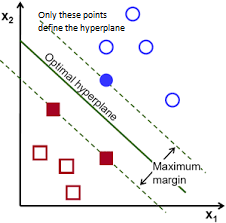

In [3]:
from IPython.display import Image
Image(filename='svm.PNG', width=300, height=300)

### k-NN Classifier 
The k-NN classifier is a unsupervised classifier that looks at the similarity measures between training samples and the test samples. It filters out the $k$ nearest neighbour (which are labelled) and accords weights to these neighbours according to their similarity measures. Different similarity measures are used - but the most popular one is cosine similarity or the simple euclidean. Sometimes, the Hamming distance is used for boolean variables.
$$
\begin{align}
  &\text{Euclidean distance}& \quad \sqrt{\sum^k_{i=1} (x_i-y_i)^2}  \\
  &\text{Cosine distance}& \quad \frac{\sum^n_{i=1} A_i B_i}{\sqrt{\sum^n_{i=1} A_i^2} \sqrt{\sum^n_{i=1} B_i^2}}
 \end{align}
$$

In the code below, the $k$ neighbours are weighted by an inverse of the distance. Note the workout in the excel sheet how the calculation is done for an intuitive feel. What happens if you use a different measure or different $k$ or even frequency/ count (which the k-NN doesn't specify.

In [39]:
# k-nn classifier

def train_knn(X, y, k, weight):
    """
    Create and train the k-nearest neighbor.
    """
    knn = KNeighborsClassifier(n_neighbors = k, weights = weight, metric = 'cosine', algorithm = 'brute')
    knn.fit(X, y)
    return knn

kn = train_knn(train_vectors, train_lab, 20, 'distance')# distance weights - by inverse of distance
predKN = kn.predict(test_vectors)
pred = list(predKN)
cm = ConfusionMatrix(pred, test_lab)
print(cm)

   |    -      |
   |    1    1 |
---+-----------+
-1 |<2536> 395 |
 1 |  530<1605>|
---+-----------+
(row = reference; col = test)



### Decision-Tree Classifier

The decision tree classifier is not often used in sentiment classification, and will not be discussed much here. One reason for this is it takes the most informative features (from the training set) and uses it in sequential splitting of the 'decision tree'. Compared to the Naive Bayes, it does not even consider the conditional distribution of the test set for classification.

In [40]:
# sklearn
def train_dtc(X, y):
    """
    Create and train the Decision Tree Classifier.
    """
    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    return dtc

dt = train_dtc(train_vectors, train_lab)
predDT = dt.predict(test_vectors)
pred = list(predDT)
cm = ConfusionMatrix(pred, test_lab)
print(cm)


   |    -      |
   |    1    1 |
---+-----------+
-1 |<2275> 358 |
 1 |  791<1642>|
---+-----------+
(row = reference; col = test)



### Selection on k-best features

This particular considers only the k-best (most informative) features to use for training. We use it to re-train the SCM model and the naive bayes model.

In [42]:
ch21 = SelectKBest(chi2, k=5000)
# Transform your training and testing datasets accordingly
train_Kbest = ch21.fit_transform(train_vectors, train_lab)
test_Kbest = ch21.transform(test_vectors)

# Train your SVM with the k best selected features
sv = train_svm(train_Kbest, train_lab)
predSVM= sv.predict(test_Kbest)
pred = list(predSVM)
cm = confusion_matrix(pred, test_lab)
print(cm)
print(accuracy_score(pred, test_lab))
print(classification_report(pred,  test_lab))

[[2714  202]
 [ 352 1798]]
0.890643505724
             precision    recall  f1-score   support

         -1       0.89      0.93      0.91      2916
          1       0.90      0.84      0.87      2150

avg / total       0.89      0.89      0.89      5066



Further, print out the most informative features.

In [46]:
clf = MultinomialNB().fit(train_Kbest, train_lab)
predNB = clf.predict(test_Kbest)
pred = list(predNB)
cm = confusion_matrix(pred, test_lab)
print(cm)
print(accuracy_score(pred, test_lab))
print(classification_report(pred,  test_lab))

# View the selected features
selected_features = list(np.array(vectorizer.get_feature_names())[ch21.get_support()])
print(selected_features)

[[2774  355]
 [ 292 1645]]
0.872285827083
             precision    recall  f1-score   support

         -1       0.90      0.89      0.90      3129
          1       0.82      0.85      0.84      1937

avg / total       0.87      0.87      0.87      5066

['00', '05', '10', '10min', '10pm', '11', '116', '12', '13', '14', '15', '16', '17', '18', '1992', '19th', '1hr', '1lb', '20', '2007', '2014', '25', '29', '2lb', '30', '30p', '33', '350', '350lbs', '36', '3x', '40', '45', '46', '48', '49ers', '4stars', '50', '545', '55', '59', '59th', '5pm', '600', '6055', '6ish', '70s', '78', '79', '80', '84', '86', '8am', '99', '9pm', 'a16', 'aaaah', 'aaron', 'abay', 'aber', 'able', 'about', 'absent', 'absolute', 'absolutely', 'absurd', 'abt', 'abysmal', 'acceptable', 'accommodated', 'accommodating', 'accomodated', 'ache', 'aches', 'achieve', 'acidic', 'acknowledge', 'acknowledged', 'acknowledgement', 'act', 'acted', 'acting', 'actions', 'actors', 'acts', 'actual', 'actually', 'addicted', 'addictin